!nvidia-smi

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


# In[2]:


#import installed libraries

import sys
from fancy_einsum import einsum

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformers import AutoTokenizer, pipeline, logging, AutoModelForCausalLM, AutoConfig
from transformer_lens import ActivationCache, HookedTransformer

from huggingface_hub import notebook_login
from datasets import Dataset
import pandas as pd
import transformers
import torch
import einops  # Make sure einops is imported
import numpy as np 

from neel_plotly import line, imshow, scatter
import transformer_lens.patching as patching
import circuitsvis as cv
import matplotlib.pyplot as plt
from pathlib import Path


# In[3]:


# Import from local libraries

from load_HookedTransformer import load_HookedTransformer
from utils import *
from datasets import load_dataset
from load_Datasets import load_and_concat_openwebtext


# In[ ]:





# In[4]:


torch.set_grad_enabled(False)
#model,tokenizer = load_HookedTransformer('llama-7b')
model,tokenizer = load_HookedTransformer('llama-7b')


# In[5]:


subset=[0]
dataset = load_and_concat_openwebtext(subset)


# In[ ]:





# In[ ]:





# In[ ]:





# In[6]:


def get_last_index(tokens, pad_token_index):
    max_len=tokens.shape[1]
    tokens=tokens[:,1:].cpu()
    
    # Create a boolean mask where the condition is True for the pad_token_index
    pad_mask = (tokens == pad_token_index)

    # However, argmax returns 0 for rows where the condition is never True (i.e., no pad_token_index found).
    # To distinguish between cases where the pad_token_index is at the start (index 0) and not present, 
    # we can use a trick: multiply the mask by a range tensor and use argmax on that.
    # If the pad token is not present in the row, the result will be 0 for that row, since the mask will be all False.

    # Generate a range tensor of the same shape as prompts
    last_index = pad_mask.int().argmax(dim=1)
    last_index[last_index==0]=max_len-1
    
    return last_index.numpy()

'''
tokens=model.to_tokens(dataset.iloc[:1000].text)
text_lengths=get_last_index(tokens)
text_lengths
plt.hist(get_last_index(prompts)+1)

# Add labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Show plot
plt.show()
'''


# In[ ]:





# In[ ]:





# In[ ]:





# In[7]:


project_name = 'final_activation_llama_set0_ctx_1024'
if not os.path.exists(project_name):
    os.mkdir(project_name)
    print(f"Directory '{project_name}' created.")
else:
    print(f"Directory '{project_name}' already exists.")

import os
import torch
from pathlib import Path

num_samples = 100000
batch_size = 5
ctx_len=1024

model.cfg.n_ctx=ctx_len

# Initialize dictionaries to hold final activations for both sets of positions
final_activations = {
    'last0': {}, 'last1': {}, 'last2': {}, 'last3': {}, 'last10': {}, 'last20': {}, 
    'pos0': {}, 'pos5': {}, 'pos10': {}, 'pos50': {}
}

target_keys_substrings = [
    "hook_attn_out",
    "hook_mlp_out",
    "hook_resid_pre",
    "hook_resid_mid",
    "hook_resid_post",
    "ln_final"
]

layer_indices = [0, 1, 2, 8, 15, 23, 29, 30, 31]
target_layers_substrings = [f"blocks.{index}" for index in layer_indices] + ["ln_final"]

# Define specific token positions

names_filter= [key for key in list(model.hook_dict.keys()) if any(substring in key for substring in target_keys_substrings)]
names_filter= [key for key in names_filter if any(substring in key for substring in target_layers_substrings)]

last_token_positions=[0,1,2,3,10,20]
token_positions = [0, 5, 10, 50]  
last_idxs=[]
for i in range(int(np.ceil(num_samples // batch_size))):
    prompts = dataset.iloc[batch_size * i : min(batch_size * (i + 1), num_samples)].text
    tokens=model.to_tokens(prompts.tolist())
    last_idx = get_last_index(tokens, pad_token_index=tokenizer.pad_token_id)
    last_idxs+=last_idx.tolist()
filtered_idx=(np.array(last_idxs)==(ctx_len-1))
dataset=dataset.iloc[np.where(filtered_idx)]

num_samples=len(dataset) 
last_idxs=[]
for i in range(int(np.ceil(num_samples // batch_size))):
    prompts = dataset.iloc[batch_size * i : min(batch_size * (i + 1), num_samples)].text
    
    tokens=model.to_tokens(prompts.tolist())
    #tokens = torch.concatenate([t[:ctx_len] for t in tokens])
    tokens=tokens[:,:ctx_len]
    last_idx = get_last_index(tokens, pad_token_index=tokenizer.pad_token_id)
    _, cache = model.run_with_cache(tokens, names_filter=names_filter)

    # Process each key in the cache
    for key in cache.keys():
        if any(substring in key for substring in target_keys_substrings):

            if hasattr(cache[key], 'shape') and len(cache[key].shape) == 3:
                # Process for last positions relative to last_idx
                for offset, suffix in zip(last_token_positions, ['last0', 'last1', 'last2', 'last3', 'last10', 'last20']):
                    position = -offset
                    slices = [cache[key][j, last_idx[j] + position, :].cpu() for j in range(len(last_idx)) if last_idx[j] + position >= 0]
                    if slices:
                        if key not in final_activations[suffix]:
                            final_activations[suffix][key] = []
                        final_activations[suffix][key].extend(slices)

                # Process for specific token positions
                for position in token_positions:
                    if tokens.shape[1] > position:  # Ensure sequence is long enough
                        slices = [cache[key][j, position, :].cpu() for j in range(tokens.shape[0]) if tokens.shape[1] > position]
                        if slices:
                            suffix = f'pos{position}'
                            if key not in final_activations[suffix]:
                                final_activations[suffix][key] = []
                            final_activations[suffix][key].extend(slices)
    last_idxs=last_idxs+list(last_idx)
    del _
    del cache
    del tokens
    torch.cuda.empty_cache()
    print(f"{batch_size * (i + 1) - 1}th samples done")

# Save the extracted slices
for suffix in final_activations.keys():
    for key, value in final_activations[suffix].items():
        if value: 
            tensor_stack = torch.stack(value, dim=0)
            torch.save(tensor_stack, Path(project_name) / f'{key}.{suffix}.pt')
            
            
torch.save(last_idxs, Path(project_name) / 'last_idxs.pt')



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model llama-7b into HookedTransformer
Directory 'final_activation_llama_set0_ctx_1024' already exists.
4th samples done
9th samples done
14th samples done
19th samples done
24th samples done


KeyboardInterrupt: 

In [ ]:
# Import from local libraries

from load_HookedTransformer import load_HookedTransformer
from utils import *
from datasets import load_dataset
from load_Datasets import load_and_concat_openwebtext

In [4]:
torch.set_grad_enabled(False)
#model,tokenizer = load_HookedTransformer('llama-7b')
model,tokenizer = load_HookedTransformer('mistral-7b')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model mistral-7b into HookedTransformer


In [5]:

def get_last_index(tokens, pad_token_index):
    max_len=tokens.shape[1]
    tokens=tokens[:,1:].cpu()
    
    # Create a boolean mask where the condition is True for the pad_token_index
    pad_mask = (tokens == pad_token_index)

    # However, argmax returns 0 for rows where the condition is never True (i.e., no pad_token_index found).
    # To distinguish between cases where the pad_token_index is at the start (index 0) and not present, 
    # we can use a trick: multiply the mask by a range tensor and use argmax on that.
    # If the pad token is not present in the row, the result will be 0 for that row, since the mask will be all False.

    # Generate a range tensor of the same shape as prompts
    last_index = pad_mask.int().argmax(dim=1)
    last_index[last_index==0]=max_len-1
    
    return last_index.numpy()

'''
tokens=model.to_tokens(dataset.iloc[:1000].text)
text_lengths=get_last_index(tokens)
text_lengths
plt.hist(get_last_index(prompts)+1)

# Add labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Show plot
plt.show()
'''

"\ntokens=model.to_tokens(dataset.iloc[:1000].text)\ntext_lengths=get_last_index(tokens)\ntext_lengths\nplt.hist(get_last_index(prompts)+1)\n\n# Add labels and title\nplt.xlabel('Text Length')\nplt.ylabel('Frequency')\nplt.title('Distribution of Text Lengths')\n\n# Show plot\nplt.show()\n"

In [50]:
project_name = 'test'
if not os.path.exists(project_name):
    os.mkdir(project_name)
    print(f"Directory '{project_name}' created.")
else:
    print(f"Directory '{project_name}' already exists.")

import os
import torch
from pathlib import Path

num_samples = 4
batch_size = 4
ctx_len=1024

model.cfg.n_ctx=1024

# Initialize dictionaries to hold final activations for both sets of positions
final_activations = {
    'last0': {}, 'last1': {}, 'last2': {}, 'last3': {}, 'last10': {}, 'last20': {}, 
    'pos0': {}, 'pos5': {}, 'pos10': {}, 'pos50': {}
}

target_keys_substrings = [
    "hook_attn_out",
    "hook_mlp_out",
    "hook_resid_pre",
    "hook_resid_mid",
    "hook_resid_post",
    "ln_final"
]

layer_indices = [0, 1, 2, 3, 8, 13, 18, 23, 28, 29, 30, 31]
target_layers_substrings = [f"blocks.{index}" for index in layer_indices]

# Define specific token positions

names_filter= [key for key in list(model.hook_dict.keys()) if any(substring in key for substring in target_keys_substrings)]
names_filter= [key for key in names_filter if any(substring in key for substring in target_layers_substrings)]

token_positions = [0, 5, 10, 50]  
last_token_positions=[0,1,2,3,10,20]
last_idxs=[]

for i in range(int(np.ceil(num_samples // batch_size))):
    prompts = dataset.iloc[batch_size * i : min(batch_size * (i + 1), num_samples)].text
    
    tokens=model.to_tokens(prompts.tolist())
    #tokens = torch.concatenate([t[:ctx_len] for t in tokens])
    tokens=tokens[:,:ctx_len]
    last_idx = get_last_index(tokens, pad_token_index=tokenizer.pad_token_id)
    _, cache = model.run_with_cache(tokens, names_filter=names_filter)

    # Process each key in the cache
    for key in cache.keys():
        if any(substring in key for substring in target_keys_substrings):

            if hasattr(cache[key], 'shape') and len(cache[key].shape) == 3:
                # Process for last positions relative to last_idx
                for offset, suffix in zip(last_token_positions, ['last0', 'last1', 'last2', 'last3', 'last10', 'last20']):
                    position = -offset
                    slices = [cache[key][j, last_idx[j] + position, :].cpu() for j in range(len(last_idx)) if last_idx[j] + position >= 0]
                    if slices:
                        if key not in final_activations[suffix]:
                            final_activations[suffix][key] = []
                        final_activations[suffix][key].extend(slices)

                # Process for specific token positions
                for position in token_positions:
                    if tokens.shape[1] > position:  # Ensure sequence is long enough
                        slices = [cache[key][j, position, :].cpu() for j in range(tokens.shape[0]) if tokens.shape[1] > position]
                        if slices:
                            suffix = f'pos{position}'
                            if key not in final_activations[suffix]:
                                final_activations[suffix][key] = []
                            final_activations[suffix][key].extend(slices)
    last_idxs=last_idxs+list(last_idx)
    del _
    del cache
    del tokens
    torch.cuda.empty_cache()
    print(f"{batch_size * (i + 1) - 1}th samples done")

# Save the extracted slices
for suffix in final_activations.keys():
    for key, value in final_activations[suffix].items():
        if value:  # Check if there are tensors to save
            tensor_stack = torch.stack(value, dim=0)
            torch.save(tensor_stack, Path(project_name) / f'{key}.{suffix}.pt')
            
            
torch.save(last_idxs, Path(project_name) / 'last_idxs.pt')


Directory 'test' already exists.
3th samples done


In [61]:
model.cfg.n_ctx

1024

In [62]:
dataset

,text
0,"Port-au-Prince, Haiti (CNN) -- Earthquake vict..."
1,Former secretary of state Hillary Clinton meet...
2,The opinions expressed by columnists are their...
3,BIGBANG is one of those musical entities that ...
4,WHAT?!??! I know. That’s what you’re saying ri...
...,...
100995,Pin 1 6 Shares\n\nWhatsapp is no doubt one of ...
100996,The AOSP codebase in big.\n\nDeveloping on the...
100997,"""Already every new train that we are bringing ..."
100998,Former acting CIA director Michael Morell said...


In [8]:
'''
project_name='final_activation_gpt2_test'
if not os.path.exists(project_name):
    os.mkdir(project_name)
    print(f"Directory '{project_name}' created.")
else:
    print(f"Directory '{project_name}' already exists.")
    

num_samples = 20
batch_size = 12

activation_tensors_last0=[]; activation_tensors_last1=[]; activation_tensors_last2=[]; activation_tensors_last3=[];
last_idxs=[]

for i in range(num_samples//batch_size+1):
    prompts = dataset.iloc[batch_size*i:min(batch_size*(i+1),num_samples)].text
    
    tokens = model.to_tokens(prompts, prepend_bos=True)
    last_idx=get_last_index(tokens)

    original_logits, cache = model.run_with_cache(tokens)

    #target_token = model.to_tokens(target_word, prepend_bos=False)

    activation_tensor_of_interest_last0=[cache["ln_final.hook_normalized"][j,last_idx[j],:].cpu() for j in range(tokens.shape[0])]
    activation_tensor_of_interest_last1=[cache["ln_final.hook_normalized"][j,last_idx[j]-1,:].cpu() for j in range(tokens.shape[0])]
    activation_tensor_of_interest_last2=[cache["ln_final.hook_normalized"][j,last_idx[j]-2,:].cpu() for j in range(tokens.shape[0])]
    activation_tensor_of_interest_last3=[cache["ln_final.hook_normalized"][j,last_idx[j]-3,:].cpu() for j in range(tokens.shape[0])]

    last_idxs=last_idxs+list(last_idx)
    activation_tensors_last0 = activation_tensors_last0 + activation_tensor_of_interest_last0
    activation_tensors_last1 = activation_tensors_last1 + activation_tensor_of_interest_last1
    activation_tensors_last2 = activation_tensors_last2 + activation_tensor_of_interest_last0
    activation_tensors_last3 = activation_tensors_last3 + activation_tensor_of_interest_last1
    del original_logits
    #del cache
    del tokens
    torch.cuda.empty_cache()
    print(f"{batch_size*(i+1)-1}th samples done")
    
# Step 3: Convert the list to a tensor stack if it's not empty
if activation_tensors_last0:
    activation_tensors_last0 = torch.stack(activation_tensors_last0,dim=0)
    activation_tensors_last1 = torch.stack(activation_tensors_last1,dim=0)
    activation_tensors_last2 = torch.stack(activation_tensors_last2,dim=0)
    activation_tensors_last3 = torch.stack(activation_tensors_last3,dim=0)
else:
    print("No activation tensors collected.")
    
# Assuming activation_tensors is your tensor
torch.save(activation_tensors_last0, Path(project_name) / 'activation_tensors_last0.pt')
torch.save(activation_tensors_last1, Path(project_name) / 'activation_tensors_last1.pt')
torch.save(activation_tensors_last2, Path(project_name) / 'activation_tensors_last2.pt')
torch.save(activation_tensors_last3, Path(project_name) / 'activation_tensors_last3.pt')

torch.save(last_idxs, Path(project_name) / 'last_idxs.pt')
'''

'\nproject_name=\'final_activation_gpt2_test\'\nif not os.path.exists(project_name):\n    os.mkdir(project_name)\n    print(f"Directory \'{project_name}\' created.")\nelse:\n    print(f"Directory \'{project_name}\' already exists.")\n    \n\nnum_samples = 20\nbatch_size = 12\n\nactivation_tensors_last0=[]; activation_tensors_last1=[]; activation_tensors_last2=[]; activation_tensors_last3=[];\nlast_idxs=[]\n\nfor i in range(num_samples//batch_size+1):\n    prompts = dataset.iloc[batch_size*i:min(batch_size*(i+1),num_samples)].text\n    \n    tokens = model.to_tokens(prompts, prepend_bos=True)\n    last_idx=get_last_index(tokens)\n\n    original_logits, cache = model.run_with_cache(tokens)\n\n    #target_token = model.to_tokens(target_word, prepend_bos=False)\n\n    activation_tensor_of_interest_last0=[cache["ln_final.hook_normalized"][j,last_idx[j],:].cpu() for j in range(tokens.shape[0])]\n    activation_tensor_of_interest_last1=[cache["ln_final.hook_normalized"][j,last_idx[j]-1,:].cpu

In [53]:
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
# Method to calculate ID

def get_ratios(vectors, n_neighbors):
    try:
        N = len(vectors)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto").fit(vectors)
        distances, indices = nbrs.kneighbors(vectors)
        ratios = np.array(
            [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
        )

    except Exception as e:
        print(f"An error occurred: {e}")
        ratios = None
        N = 0

    return ratios, N


def measure_dimension_kNN(
    vectors, n_neighbors=5, fraction=0.9, plot=False, verbose=False
):
    ratios, N = get_ratios(vectors, n_neighbors)
    try:
        mus = [
            np.sort(ratios[i], axis=None, kind="quicksort") for i in range(n_neighbors - 2)
        ]
        Femp = (np.arange(1, N + 1, dtype=np.float64)) / N

        dims = []
        xs = []
        ys = []
        for k, mu in enumerate(mus):
            x = np.log(mu[:-2])
            xs += [x]
            y = -np.log(1 - Femp[:-2] ** (1 / (k + 1)))
            ys += [y]

            npoints = int(np.floor(N * fraction))
            regr = linear_model.LinearRegression(fit_intercept=False)
            regr.fit(x[:npoints, np.newaxis], y[:npoints, np.newaxis])
            if verbose:
                print(
                    "From ratio " + str(k + 2) + " NN estimated dim " + str(regr.coef_[0])
                )
            dims += [regr.coef_[0]]

        if plot:
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.set_title("Log F vs Log mu")
            ax.set_xscale("linear")
            ax.set_yscale("linear")
            for x, y, dim in zip(xs, ys, dims):
                ax.scatter(x[:npoints], y[:npoints])
                ax.plot(
                    x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
                )
                ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
        #print(x[:npoints],regr.predict(x[:npoints].reshape((-1, 1)) ))
        return xs, ys, dims, fig
    except:
        return None, None, None, None


def measure_dimension_MLE(vectors, n_neighbors=10, plot=False, verbose=False):
    ratios, _ = get_ratios(vectors, n_neighbors)
    logs = np.log(ratios)
    estimates = (n_neighbors - 2) / (logs[:, -1] - np.sum(logs[:, :-1], axis=1))
    dim = np.mean(estimates)
    var = np.var(estimates)
    if verbose:
        print("Dimension MLE: ", dim, " Stddev: ", np.sqrt(var))
    if plot:
        fig, axs = plt.subplots(1, 1)
        axs.hist(estimates, bins=50)

    return dim, var, estimates

blocks.29.hook_resid_post.pos5.pt


NameError: name 'torch' is not defined

blocks.11.hook_resid_mid.pos0.pt


/state/partition1/slurm_tmp/25646023.0.0/ipykernel_1664474/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


blocks.25.hook_resid_post.last2.pt
From ratio 2 NN estimated dim [106.56399933]
From ratio 3 NN estimated dim [137.45925678]
From ratio 4 NN estimated dim [146.85876639]
blocks.17.hook_attn_out.pos50.pt
From ratio 2 NN estimated dim [362.4455811]
From ratio 3 NN estimated dim [146.44818843]
From ratio 4 NN estimated dim [120.0018864]
plot_ID_blocks.24.hook_resid_mid.pos1.png


/state/partition1/slurm_tmp/25646023.0.0/ipykernel_1664474/2861130863.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25646023.0.0/ipykernel_1664474/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

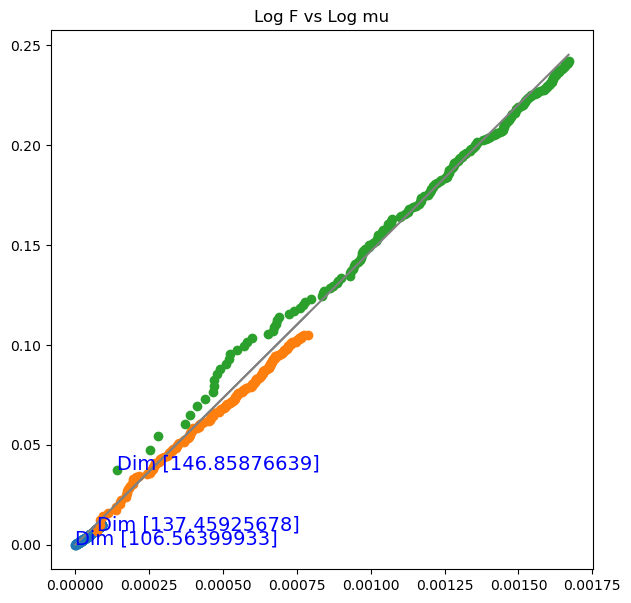

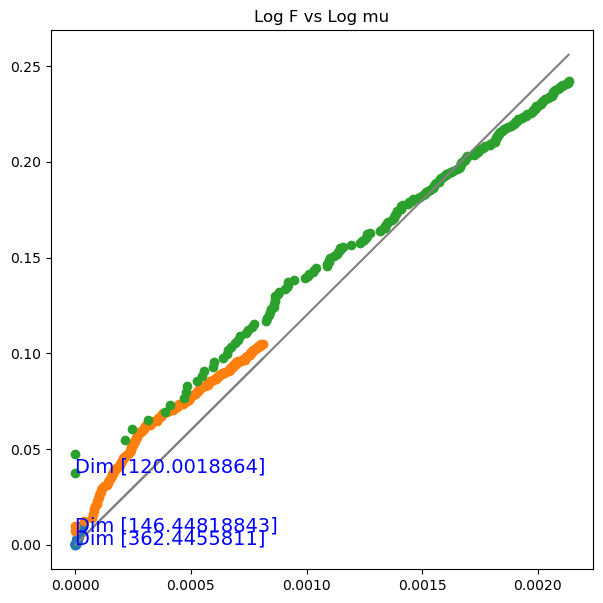

In [58]:
project_name='final_activation_llama_set0_ctx_2024'
for file in os.listdir(project_name)[:10]:
    if file !='last_idxs.pt':
        print(file)
        activation_tensors0 = torch.load(Path(project_name)/file)
        xs, ys, dims, fig = measure_dimension_kNN(activation_tensors0, n_neighbors=5, fraction=0.01, plot=True, verbose=True)
        #if fig is not None:
        #    fig.savefig(Path(project_name) / ('plot_ID_'+file.replace(".pt", ".png")))

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [28.97126129]
From ratio 3 NN estimated dim [30.19129101]
From ratio 4 NN estimated dim [25.40014658]
From ratio 2 NN estimated dim [40.13882677]
From ratio 3 NN estimated dim [26.11159516]
From ratio 4 NN estimated dim [26.49812099]
From ratio 2 NN estimated dim [23.71231499]
From ratio 3 NN estimated dim [23.26394969]
From ratio 4 NN estimated dim [24.10786609]
From ratio 2 NN estimated dim [35.45973499]
From ratio 3 NN estimated dim [29.91639319]
From ratio 4 NN estimated dim [29.64636425]
From ratio 2 NN estimated dim [45.99206232]
From ratio 3 NN estimated dim [36.8439838]
From ratio 4 NN estimated dim [38.0535089]
From ratio 2 NN estimated dim [8.81779339]
From ratio 3 NN estimated dim [12.13237036]
From ratio 4 NN estimated dim [12.36719378]
From ratio 2 NN estimated dim [40.70341723]
From ratio 3 NN estimated dim [39.21574083]
From ratio 4 NN estimated dim [37.09305248]
From ratio 2 NN estimated dim [40.58359748]
From ratio 3 NN estimated dim [33.5

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, 7))


From ratio 2 NN estimated dim [32.73043322]
From ratio 3 NN estimated dim [18.20684071]
From ratio 4 NN estimated dim [16.47117028]
From ratio 2 NN estimated dim [49.2245947]
From ratio 3 NN estimated dim [48.37979436]
From ratio 4 NN estimated dim [38.53157131]
From ratio 2 NN estimated dim [12.52966294]
From ratio 3 NN estimated dim [13.09274083]
From ratio 4 NN estimated dim [13.14324728]
From ratio 2 NN estimated dim [32.30310526]
From ratio 3 NN estimated dim [32.37314492]
From ratio 4 NN estimated dim [30.19176531]
From ratio 2 NN estimated dim [20.31155862]
From ratio 3 NN estimated dim [16.68826061]
From ratio 4 NN estimated dim [9.67001677]
From ratio 2 NN estimated dim [18.34160916]
From ratio 3 NN estimated dim [18.96459154]
From ratio 4 NN estimated dim [16.547961]
From ratio 2 NN estimated dim [60.90187373]
From ratio 3 NN estimated dim [46.68646736]
From ratio 4 NN estimated dim [45.99207951]
From ratio 2 NN estimated dim [4.1440969]
From ratio 3 NN estimated dim [6.03260

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [21.087346]
From ratio 3 NN estimated dim [23.12533065]
From ratio 4 NN estimated dim [22.06081455]
From ratio 2 NN estimated dim [17.29585943]
From ratio 3 NN estimated dim [17.73171643]
From ratio 4 NN estimated dim [17.97645531]
From ratio 2 NN estimated dim [65.2308061]
From ratio 3 NN estimated dim [56.14477393]
From ratio 4 NN estimated dim [45.14368645]
From ratio 2 NN estimated dim [20.18806253]
From ratio 3 NN estimated dim [22.07231346]
From ratio 4 NN estimated dim [21.12851049]
From ratio 2 NN estimated dim [24.3922505]
From ratio 3 NN estimated dim [26.26915338]
From ratio 4 NN estimated dim [23.66392083]
From ratio 2 NN estimated dim [24.85053078]
From ratio 3 NN estimated dim [27.73042974]
From ratio 4 NN estimated dim [29.78486791]
From ratio 2 NN estimated dim [12.60135059]
From ratio 3 NN estimated dim [15.13693963]
From ratio 4 NN estimated dim [12.39549769]
From ratio 2 NN estimated dim [2.83081748]
From ratio 3 NN estimated dim [3.9465

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [26.63166048]
From ratio 3 NN estimated dim [22.17226818]
From ratio 4 NN estimated dim [17.89325676]
From ratio 2 NN estimated dim [10.17794589]
From ratio 3 NN estimated dim [9.65005404]
From ratio 4 NN estimated dim [8.93436591]
From ratio 2 NN estimated dim [59.78790102]
From ratio 3 NN estimated dim [53.78842076]
From ratio 4 NN estimated dim [45.73969432]
From ratio 2 NN estimated dim [43.8093908]
From ratio 3 NN estimated dim [37.05354613]
From ratio 4 NN estimated dim [33.09544374]
From ratio 2 NN estimated dim [27.37086404]
From ratio 3 NN estimated dim [25.8578102]
From ratio 4 NN estimated dim [25.03850594]


/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [32.03385829]
From ratio 3 NN estimated dim [31.41202601]
From ratio 4 NN estimated dim [23.20632491]
From ratio 2 NN estimated dim [11.05014899]
From ratio 3 NN estimated dim [12.31772476]
From ratio 4 NN estimated dim [12.80415337]
From ratio 2 NN estimated dim [47.60540252]
From ratio 3 NN estimated dim [50.96419599]
From ratio 4 NN estimated dim [41.8086947]
From ratio 2 NN estimated dim [33.73552212]
From ratio 3 NN estimated dim [34.83524879]
From ratio 4 NN estimated dim [32.06805682]
From ratio 2 NN estimated dim [73.9680857]
From ratio 3 NN estimated dim [51.43755396]
From ratio 4 NN estimated dim [45.26243152]
From ratio 2 NN estimated dim [55.30665091]
From ratio 3 NN estimated dim [35.92959848]
From ratio 4 NN estimated dim [23.45140127]
From ratio 2 NN estimated dim [64.1924195]
From ratio 3 NN estimated dim [60.67374874]
From ratio 4 NN estimated dim [55.94552161]
From ratio 2 NN estimated dim [29.76502047]
From ratio 3 NN estimated dim [38.9

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [20.59295383]
From ratio 3 NN estimated dim [18.48295171]
From ratio 4 NN estimated dim [16.77972873]
From ratio 2 NN estimated dim [13.87753973]
From ratio 3 NN estimated dim [12.92278456]
From ratio 4 NN estimated dim [13.2965193]
From ratio 2 NN estimated dim [42.02151045]
From ratio 3 NN estimated dim [40.47851472]
From ratio 4 NN estimated dim [34.91264582]
From ratio 2 NN estimated dim [23.8792878]
From ratio 3 NN estimated dim [27.24680027]
From ratio 4 NN estimated dim [24.31351004]
From ratio 2 NN estimated dim [13.21004775]
From ratio 3 NN estimated dim [14.87503244]
From ratio 4 NN estimated dim [15.83557202]
From ratio 2 NN estimated dim [52.18872467]
From ratio 3 NN estimated dim [45.23516378]
From ratio 4 NN estimated dim [44.14721659]
From ratio 2 NN estimated dim [29.59601708]
From ratio 3 NN estimated dim [30.36062014]
From ratio 4 NN estimated dim [22.13310185]
From ratio 2 NN estimated dim [26.73177468]
From ratio 3 NN estimated dim [28.

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [57.95848223]
From ratio 3 NN estimated dim [51.47541295]
From ratio 4 NN estimated dim [41.99091308]
From ratio 2 NN estimated dim [19.93868465]
From ratio 3 NN estimated dim [20.13422849]
From ratio 4 NN estimated dim [21.2923396]
From ratio 2 NN estimated dim [39.73889957]
From ratio 3 NN estimated dim [34.35930116]
From ratio 4 NN estimated dim [26.98354459]
From ratio 2 NN estimated dim [27.02928798]
From ratio 3 NN estimated dim [22.01692383]
From ratio 4 NN estimated dim [23.58823489]
From ratio 2 NN estimated dim [32.70533937]
From ratio 3 NN estimated dim [36.61929568]
From ratio 4 NN estimated dim [33.39446969]
From ratio 2 NN estimated dim [17.26542368]
From ratio 3 NN estimated dim [17.54952768]
From ratio 4 NN estimated dim [19.34941605]
From ratio 2 NN estimated dim [23.06975394]
From ratio 3 NN estimated dim [19.34544162]
From ratio 4 NN estimated dim [14.4323412]
From ratio 2 NN estimated dim [26.63898874]
From ratio 3 NN estimated dim [22.

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [26.99820427]
From ratio 3 NN estimated dim [26.65450935]
From ratio 4 NN estimated dim [23.79887121]
From ratio 2 NN estimated dim [11.30683367]
From ratio 3 NN estimated dim [9.65662153]
From ratio 4 NN estimated dim [10.13681857]
From ratio 2 NN estimated dim [64.43252526]
From ratio 3 NN estimated dim [48.12610877]
From ratio 4 NN estimated dim [33.35693877]
From ratio 2 NN estimated dim [24.38418052]
From ratio 3 NN estimated dim [23.27420819]
From ratio 4 NN estimated dim [20.91017699]
From ratio 2 NN estimated dim [10.62108592]
From ratio 3 NN estimated dim [11.09348677]
From ratio 4 NN estimated dim [10.55888874]
From ratio 2 NN estimated dim [14.08924372]
From ratio 3 NN estimated dim [17.80497978]
From ratio 4 NN estimated dim [19.65770386]


/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [24.04499339]
From ratio 3 NN estimated dim [23.95164682]
From ratio 4 NN estimated dim [23.96529946]
From ratio 2 NN estimated dim [10.71020595]
From ratio 3 NN estimated dim [9.48144283]
From ratio 4 NN estimated dim [9.71311792]
From ratio 2 NN estimated dim [18.74518783]
From ratio 3 NN estimated dim [17.4798176]


/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 4 NN estimated dim [15.6568851]
From ratio 2 NN estimated dim [16.79728752]
From ratio 3 NN estimated dim [17.98157287]
From ratio 4 NN estimated dim [14.10314418]
From ratio 2 NN estimated dim [22.15306456]
From ratio 3 NN estimated dim [18.2394714]
From ratio 4 NN estimated dim [16.37080179]
From ratio 2 NN estimated dim [25.68556783]
From ratio 3 NN estimated dim [21.43437797]
From ratio 4 NN estimated dim [19.04413451]
From ratio 2 NN estimated dim [19.30614394]
From ratio 3 NN estimated dim [24.00768276]
From ratio 4 NN estimated dim [23.52312114]
From ratio 2 NN estimated dim [32.12885432]
From ratio 3 NN estimated dim [32.31420272]
From ratio 4 NN estimated dim [32.35865831]
From ratio 2 NN estimated dim [15.22502341]
From ratio 3 NN estimated dim [16.28188986]
From ratio 4 NN estimated dim [14.57304856]
From ratio 2 NN estimated dim [21.5906714]
From ratio 3 NN estimated dim [22.28742305]
From ratio 4 NN estimated dim [17.02581327]


/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [18.43247357]
From ratio 3 NN estimated dim [20.52752012]
From ratio 4 NN estimated dim [21.29695044]
From ratio 2 NN estimated dim [46.44713931]
From ratio 3 NN estimated dim [12.29415275]
From ratio 4 NN estimated dim [6.24309235]
From ratio 2 NN estimated dim [0.73446907]
From ratio 3 NN estimated dim [0.79395807]
From ratio 4 NN estimated dim [0.84907068]
From ratio 2 NN estimated dim [15.24601023]
From ratio 3 NN estimated dim [11.82246531]
From ratio 4 NN estimated dim [10.87838991]
From ratio 2 NN estimated dim [29.11275307]
From ratio 3 NN estimated dim [23.87991452]
From ratio 4 NN estimated dim [24.24660184]
From ratio 2 NN estimated dim [50.47201659]
From ratio 3 NN estimated dim [39.54581792]
From ratio 4 NN estimated dim [37.98761104]
From ratio 2 NN estimated dim [11.18940237]
From ratio 3 NN estimated dim [7.31718854]
From ratio 4 NN estimated dim [7.45155967]
From ratio 2 NN estimated dim [2.48325343]
From ratio 3 NN estimated dim [3.473542

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [26.69583431]
From ratio 3 NN estimated dim [16.50226833]
From ratio 4 NN estimated dim [16.75813028]
From ratio 2 NN estimated dim [46.29409409]
From ratio 3 NN estimated dim [33.57753759]
From ratio 4 NN estimated dim [34.08613568]
From ratio 2 NN estimated dim [29.01092153]
From ratio 3 NN estimated dim [22.71460323]
From ratio 4 NN estimated dim [22.00432752]
From ratio 2 NN estimated dim [61.35115476]
From ratio 3 NN estimated dim [46.84494238]
From ratio 4 NN estimated dim [46.33152739]
From ratio 2 NN estimated dim [41.1513974]
From ratio 3 NN estimated dim [38.90644641]
From ratio 4 NN estimated dim [39.21178509]
From ratio 2 NN estimated dim [44.23211957]
From ratio 3 NN estimated dim [11.98570994]
From ratio 4 NN estimated dim [8.48845911]
From ratio 2 NN estimated dim [4.62285316]
From ratio 3 NN estimated dim [6.76243927]
From ratio 4 NN estimated dim [7.79333892]
From ratio 2 NN estimated dim [29.16683927]
From ratio 3 NN estimated dim [28.569

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [21.0235573]
From ratio 3 NN estimated dim [10.96124772]
From ratio 4 NN estimated dim [10.985783]
From ratio 2 NN estimated dim [52.93405455]
From ratio 3 NN estimated dim [46.22292242]
From ratio 4 NN estimated dim [42.55354995]
From ratio 2 NN estimated dim [20.78769783]
From ratio 3 NN estimated dim [20.59833969]
From ratio 4 NN estimated dim [19.50699146]
From ratio 2 NN estimated dim [18.53254732]
From ratio 3 NN estimated dim [21.04850146]
From ratio 4 NN estimated dim [19.5182697]
From ratio 2 NN estimated dim [13.87753973]
From ratio 3 NN estimated dim [12.92278456]
From ratio 4 NN estimated dim [13.2965193]
From ratio 2 NN estimated dim [21.54380831]
From ratio 3 NN estimated dim [21.07892737]
From ratio 4 NN estimated dim [17.05904422]
From ratio 2 NN estimated dim [53.86423665]
From ratio 3 NN estimated dim [50.71355656]
From ratio 4 NN estimated dim [42.71418472]
From ratio 2 NN estimated dim [41.67461906]
From ratio 3 NN estimated dim [34.611

/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [40.67971134]
From ratio 3 NN estimated dim [43.32113821]
From ratio 4 NN estimated dim [44.79990717]
From ratio 2 NN estimated dim [21.52442383]
From ratio 3 NN estimated dim [13.41834551]
From ratio 4 NN estimated dim [13.51075812]
From ratio 2 NN estimated dim [33.16862144]
From ratio 3 NN estimated dim [22.15679179]
From ratio 4 NN estimated dim [15.09101874]
From ratio 2 NN estimated dim [19.14005575]
From ratio 3 NN estimated dim [19.74377677]
From ratio 4 NN estimated dim [20.45693619]


/state/partition1/slurm_tmp/25624217.0.0/ipykernel_1020865/2861130863.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [17.91420704]
From ratio 3 NN estimated dim [19.96992639]
From ratio 4 NN estimated dim [16.94023305]
From ratio 2 NN estimated dim [25.55830351]
From ratio 3 NN estimated dim [19.17471007]
From ratio 4 NN estimated dim [16.56913911]
From ratio 2 NN estimated dim [19.26104135]
From ratio 3 NN estimated dim [23.79569421]
From ratio 4 NN estimated dim [25.40586001]
From ratio 2 NN estimated dim [32.93275301]
From ratio 3 NN estimated dim [33.1148557]
From ratio 4 NN estimated dim [25.89402894]
From ratio 2 NN estimated dim [31.9751243]
From ratio 3 NN estimated dim [31.79941597]
From ratio 4 NN estimated dim [29.55609136]
From ratio 2 NN estimated dim [8.54772265]
From ratio 3 NN estimated dim [8.79550998]
From ratio 4 NN estimated dim [9.02307833]
From ratio 2 NN estimated dim [20.02601194]
From ratio 3 NN estimated dim [22.15649167]
From ratio 4 NN estimated dim [16.74952132]


KeyboardInterrupt: 

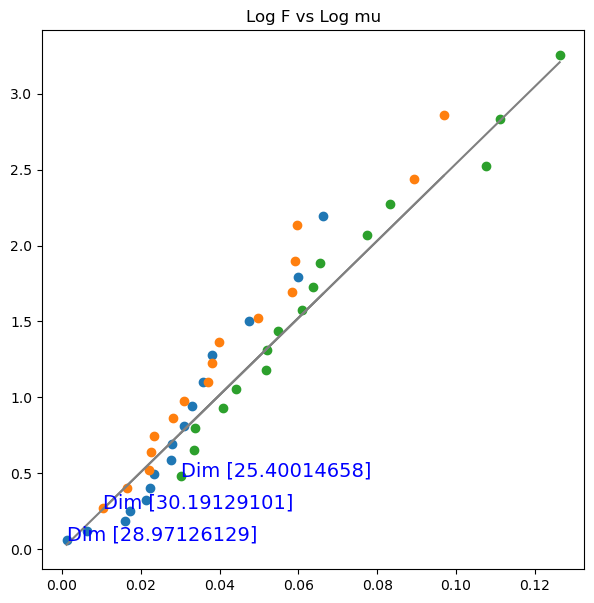

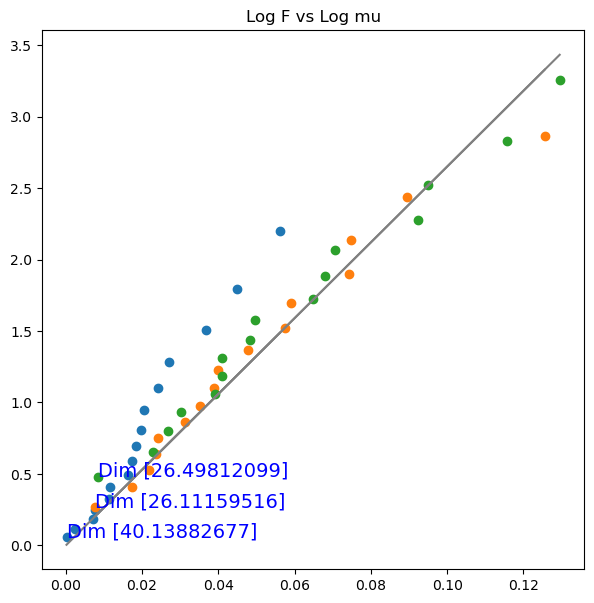

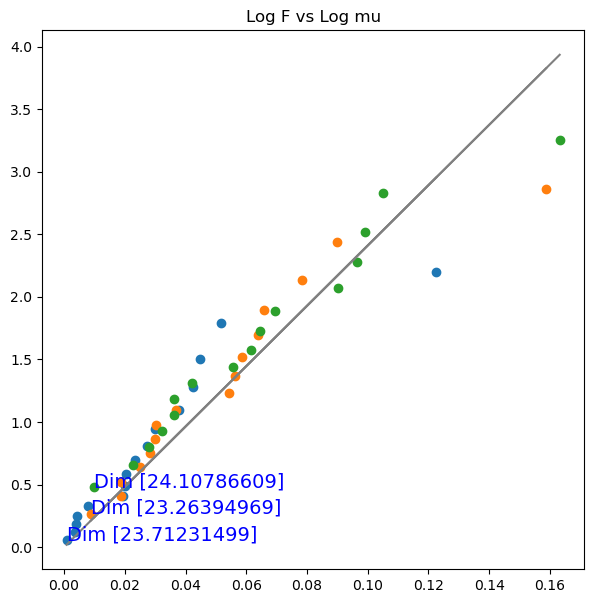

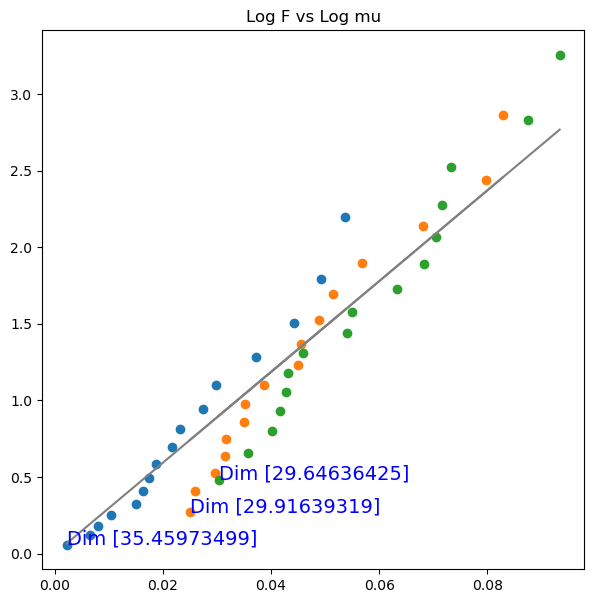

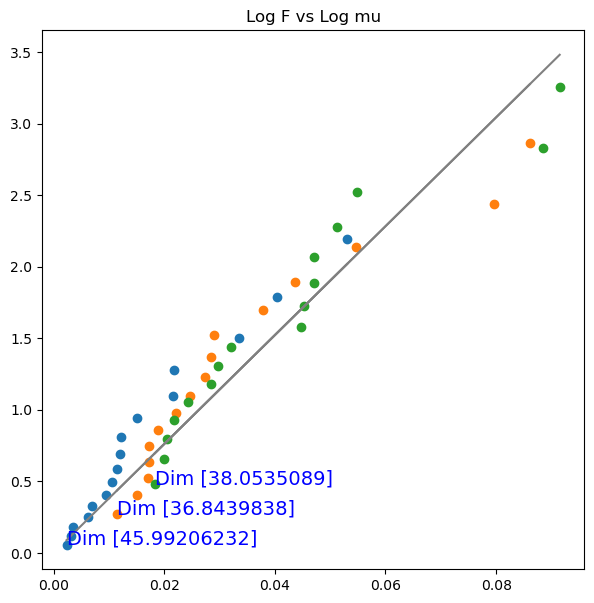

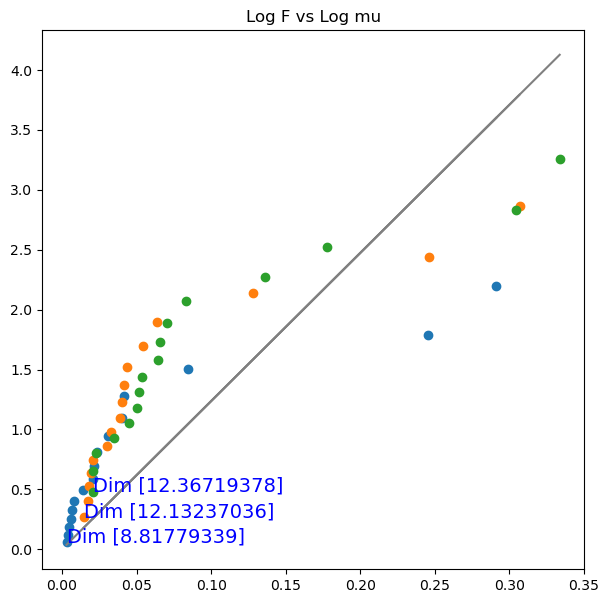

Error in callback <function flush_figures at 0x7efc20d1b940> (for post_execute):



KeyboardInterrupt



In [19]:
project_name='final_activation_llama_set0'
for file in os.listdir(project_name)[:]:
    if file !='last_idxs.pt':
        activation_tensors0 = torch.load(Path(project_name)/file)
        xs, ys, dims, fig = measure_dimension_kNN(activation_tensors0, n_neighbors=5, fraction=0.05, plot=True, verbose=True)
        if fig is not None:
            fig.savefig(Path(project_name) / ('plot_ID_'+file.replace(".pt", ".png")))